In [59]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [90]:
class MemoryMappedGlucoseDataset(Dataset):
    def __init__(self, root_dir):
        """
        Args:
            root_dir (str): Path to the root folder containing patient folders.
        """
        self.root_dir = root_dir
        self.patient_folders = sorted([
            f for f in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, f))
        ])
    
    def __len__(self):
        return len(self.patient_folders)

    def __getitem__(self, idx):
        """
        Loads a patient's glucose.csv file using memory mapping.
        Returns:
            X: Torch tensor of glucose readings.
            y: Corresponding target labels (e.g., next glucose value or classification label).
        """
        patient_folder = self.patient_folders[idx]x
        patient_glucose_path = os.path.join(self.root_dir, patient_folder, 'glucose.csv')

        if not os.path.exists(patient_glucose_path):
            raise FileNotFoundError(f"Missing file: {patient_glucose_path}")

        # Load glucose data with memory mapping
        glucose_df = pd.read_csv(patient_glucose_path, memory_map=True)
        
        # Convert to NumPy (assuming glucose values are in a column named 'glucose')
        X = glucose_df['glucose'].iloc[0:100].values  # All but last column
        y = glucose_df['glucose'].iloc[100:110].values   # Last column (e.g., target glucose levels)

        # Convert to PyTorch tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)

        return X_tensor, y_tensor

In [91]:
from torch.utils.data import Dataset, DataLoader, random_split

# Directory containing all patient subfolders
root_dir = "/home/sncr0/data/d1namo/diabetes_subset_pictures-glucose-food-insulin/diabetes_subset_pictures-glucose-food-insulin"

# Create dataset
dataset = MemoryMappedGlucoseDataset(root_dir)

# Split into train (80%) and test (20%) datasets
train_size = int(0.5 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

# Example: Iterate through batches
for test_X_batch, test_y_batch in test_loader:
    print("Test Batch X shape:", test_X_batch.shape)
    print("Test Batch y shape:", test_y_batch.shape)
    break  # Remove this to loop through all batches

# Example: Iterate through batches
for train_X_batch, train_y_batch in train_loader:
    print("Train Batch X shape:", train_X_batch.shape)
    print("Train Batch y shape:", train_y_batch.shape)
    break  # Remove this to loop through all batches

Test Batch X shape: torch.Size([4, 100])
Test Batch y shape: torch.Size([4, 10])
Train Batch X shape: torch.Size([4, 100])
Train Batch y shape: torch.Size([4, 10])


In [106]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define a simple fully connected regression model
class GlucoseRegressor(nn.Module):
    def __init__(self, input_size):
        super(GlucoseRegressor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 10)  # Output a single value
        )

    def forward(self, x):
        return self.model(x).squeeze()  # Ensure output is [batch_size]


In [113]:
# Initialize Model
input_size = 100  # Matches X shape
model = GlucoseRegressor(input_size)
criterion = nn.MSELoss()  # Regression loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1/5, Loss: 56.2515
Epoch 2/5, Loss: 49.1036
Epoch 3/5, Loss: 42.9125
Epoch 4/5, Loss: 37.6586
Epoch 5/5, Loss: 32.4155


In [114]:
# Switch to evaluation mode
model.eval()

# Get a sample batch
X_sample, y_sample = next(iter(test_loader))
y_pred_sample = model(X_sample)

# Print sample predictions
print("True y:", y_sample.tolist())
print("Predicted y:", y_pred_sample.tolist())


True y: [[2.4000000953674316, 2.299999952316284, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716, 2.200000047683716], [9.699999809265137, 9.699999809265137, 9.5, 9.199999809265137, 8.899999618530273, 8.600000381469727, 8.600000381469727, 8.800000190734863, 9.199999809265137, 9.699999809265137], [8.800000190734863, 8.699999809265137, 8.600000381469727, 8.5, 8.5, 8.399999618530273, 8.399999618530273, 8.399999618530273, 8.399999618530273, 8.300000190734863], [4.199999809265137, 4.400000095367432, 4.5, 4.599999904632568, 4.599999904632568, 4.599999904632568, 4.400000095367432, 4.300000190734863, 4.099999904632568, 3.9000000953674316]]
Predicted y: [[1.1305506229400635, 2.1589179039001465, 1.760513186454773, 1.1618372201919556, 3.2817132472991943, 2.513845205307007, 0.8542866706848145, 3.969196081161499, 0.29152247309684753, 1.2651054859161377], [2.8723843097686768, 4.118574619293213, 3.2968361377716064, 1.7

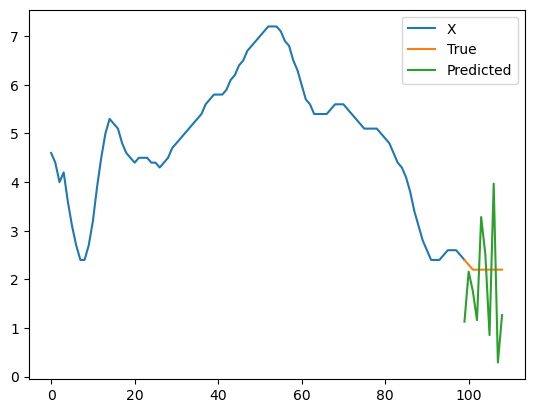

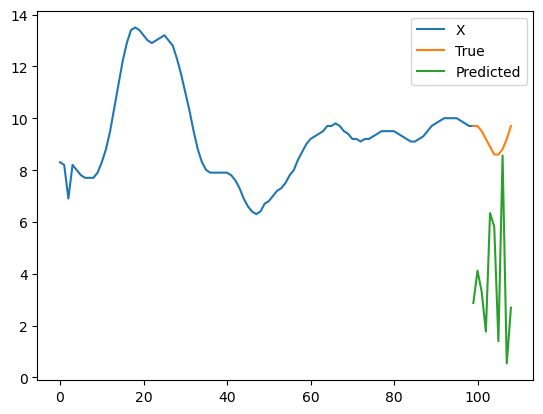

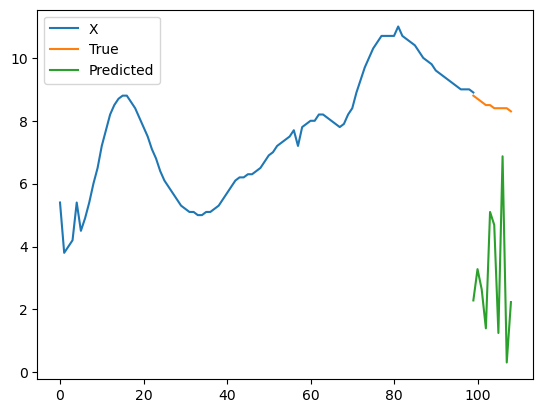

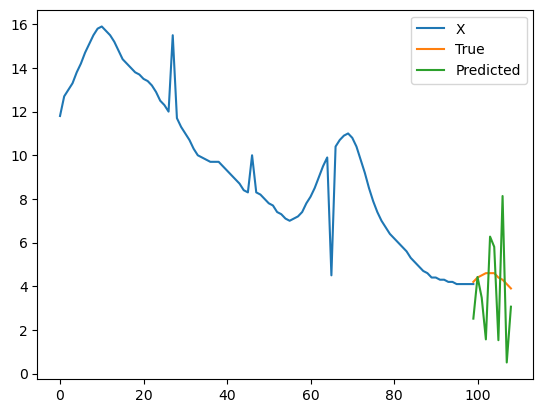

In [118]:
for y, y_pred, X in zip(y_sample, y_pred_sample, X_sample):
    plt.plot(X.detach().numpy(), label='X')
    plt.plot(np.linspace(99,108, 10), y.detach().numpy(), label='True')
    plt.plot(np.linspace(99,108, 10), y_pred.detach().numpy(), label='Predicted')
    plt.legend()
    plt.show()